In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
print("Num GPUs Available: ",len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
print(tf.version.VERSION)

2.6.0


In [5]:
import sys
sys.version

'3.9.16 (main, Jan 11 2023, 16:16:36) [MSC v.1916 64 bit (AMD64)]'

In [6]:
import numpy as np
import pickle
from os import listdir
import cv2

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.utils import class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import os 
from random import shuffle

# Loading the Data

In [7]:
import numpy as np
import pandas as pd  
import os 
from sklearn.datasets import load_files

In [8]:
data_dir =  r'C:\Users\Lenovo\Desktop\Herbis_Universalis\gimage_scraper\img'
#Desktop\Herbis_Universalis\gimage_scraper\scraped_images
data = load_files(data_dir)

# Data Preprocessing and exploring

In [9]:
folders=os.listdir(r'C:\Users\Lenovo\Desktop\Herbis_Universalis\gimage_scraper\img')
print(folders)

['chaplu', 'fahthalinejol', 'horapa', 'krapao', 'lemon', 'magrud', 'plu', 'sabtiger', 'saranae', 'yanang']


In [10]:
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])

print('Data files - ',X)
print('Target labels - ',y)

Data files -  ['C:\\Users\\Lenovo\\Desktop\\Herbis_Universalis\\gimage_scraper\\img\\fahthalinejol\\aug_0_1298.jpg'
 'C:\\Users\\Lenovo\\Desktop\\Herbis_Universalis\\gimage_scraper\\img\\sabtiger\\aug_0_8336.jpg'
 'C:\\Users\\Lenovo\\Desktop\\Herbis_Universalis\\gimage_scraper\\img\\fahthalinejol\\aug_0_5026.jpg'
 ...
 'C:\\Users\\Lenovo\\Desktop\\Herbis_Universalis\\gimage_scraper\\img\\krapao\\aug_0_1918.jpg'
 'C:\\Users\\Lenovo\\Desktop\\Herbis_Universalis\\gimage_scraper\\img\\yanang\\aug_0_372.jpg'
 'C:\\Users\\Lenovo\\Desktop\\Herbis_Universalis\\gimage_scraper\\img\\horapa\\aug_0_6768.jpg']
Target labels -  [1 7 1 ... 3 9 2]


# Load the images

In [11]:
from keras.preprocessing.image import img_to_array, load_img

def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 128,128
    for file_path in file_path_list:
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        arr.append(img)
        
    return arr
 
X = np.array(convert_img_to_arr(X))
print(X.shape)
print(y.shape)

(10565, 128, 128, 3)
(10565,)


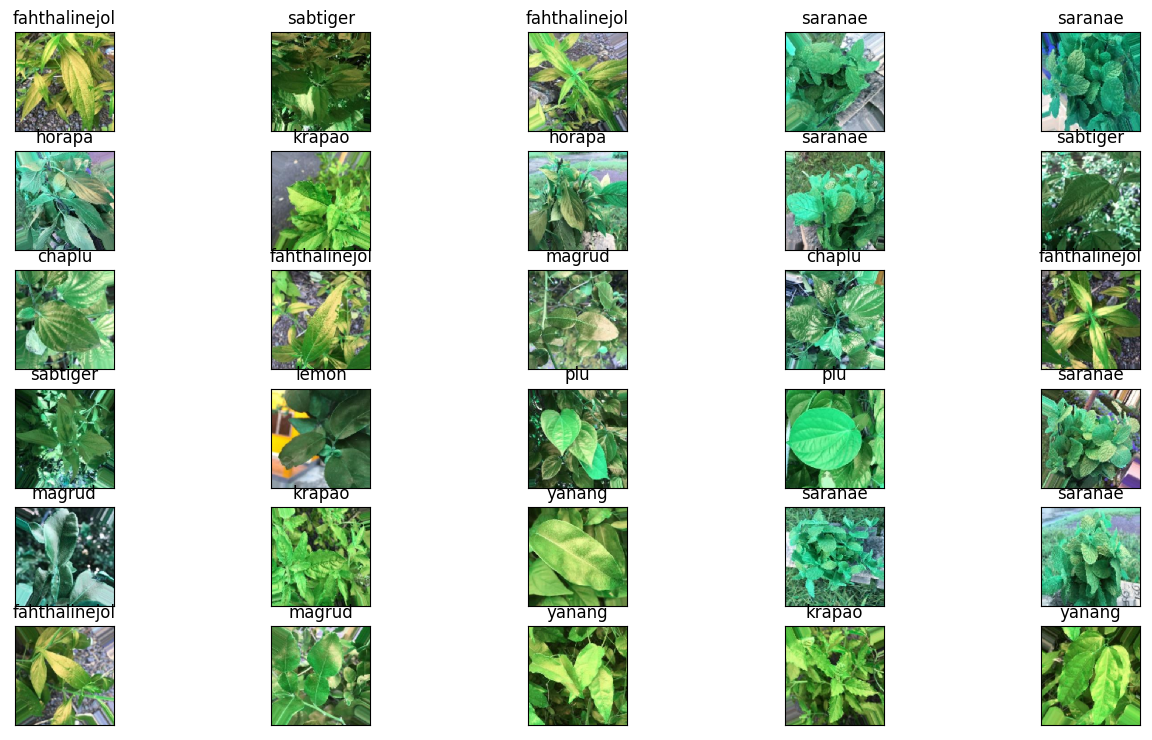

In [12]:
import matplotlib.pyplot as plt
 
fig = plt.figure(figsize = (16,9))
for i in range(30):
    ax = fig.add_subplot(6,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [13]:
X = X.astype('float32')/255
no_of_classes = len(np.unique(y))
no_of_classes

10

In [14]:
y

array([1, 7, 1, ..., 3, 9, 2])

# converts a class vector (integers) to binary class matrix

In [15]:
from keras.utils import np_utils
y = np.array(np_utils.to_categorical(y,no_of_classes))
y[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [16]:
 #80% train, 10% validation, and 10% test.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,train_size=0.7,shuffle=True)

X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.15)

In [17]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (128, 128, 3)


# Model

In [18]:
base_model =tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,input_shape=(128,128,3))

In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [20]:
base_model.trainable = False

# Add head 

In [21]:
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
prediction_layer = tf.keras.layers.Dense(units=no_of_classes,activation='softmax')(average_pooling_layer)

In [22]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

# train model

In [24]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy",metrics=["accuracy"])

C:\Users\Lenovo\anaconda3\envs\Tensorflow_GPU\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
model.fit(X_train,y_train,epochs=150,validation_data=(X_valid,y_valid),batch_size=128)

Epoch 1/150
58/58 [==============================] - 45s 161ms/step - loss: 2.0874 - accuracy: 0.2607 - val_loss: 1.6750 - val_accuracy: 0.4370
Epoch 2/150
58/58 [==============================] - 5s 82ms/step - loss: 1.3639 - accuracy: 0.6091 - val_loss: 1.1208 - val_accuracy: 0.7122
Epoch 3/150
58/58 [==============================] - 5s 81ms/step - loss: 0.9080 - accuracy: 0.8009 - val_loss: 0.7702 - val_accuracy: 0.8487
Epoch 4/150
58/58 [==============================] - 5s 82ms/step - loss: 0.6275 - accuracy: 0.8771 - val_loss: 0.5538 - val_accuracy: 0.8908
Epoch 5/150
58/58 [==============================] - 5s 82ms/step - loss: 0.4564 - accuracy: 0.9155 - val_loss: 0.4202 - val_accuracy: 0.9076
Epoch 6/150
58/58 [==============================] - 5s 83ms/step - loss: 0.3489 - accuracy: 0.9375 - val_loss: 0.3333 - val_accuracy: 0.9265
Epoch 7/150
58/58 [==============================] - 5s 83ms/step - loss: 0.2774 - accuracy: 0.9531 - val_loss: 0.2735 - val_accuracy: 0.9433
Epoc

In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(X_test, y_test, batch_size= 128, verbose=2)
print("Accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("Loss: {}".format(eval_loss))

# Acuuracy and Loss graphs

In [ ]:
def visualize_pred(y_pred):
    fig = plt.figure(figsize=(20, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=20, replace=False)):
        ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(model.predict(X_test))

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (40,40))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
len(model.layers)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
print("*******************Confusion matrix*******************")
print(confusion_matrix(Y_true,Y_pred_classes))
print("\n*******************Classification report*******************")
print(classification_report(Y_true,Y_pred_classes))